## Imports

In [1]:
import glob
import os
import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow import keras
import torch

import dgl
import networkx as nx
from stellargraph import StellarGraph
from stellargraph.mapper import GraphSAGELinkGenerator, GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import EdgeSplitter, UnsupervisedSampler

%matplotlib inline

2022-08-06 00:16:03.213985: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-06 00:16:03.214019: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Using backend: pytorch
2022-08-06 00:16:05.729373: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-06 00:16:05.729433: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (artem-VLT-WX0): /proc/driver/nvidia/version does not exist
2022-08-06 00:16:05.730076: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-crit

In [2]:
DATA_DIR = "data"
INTERIM_DIR = "interim"
MODELS = "models"
pp = pprint.PrettyPrinter(indent=4)

## GraphSAGE

The approach is similar to the previously used, we use unsupervised GraphSAGE model from the <a href="https://arxiv.org/abs/1706.02216">article</a> to get the representations of graph nodes and then use those embeddings to try to predict the node class.

#### Graph preparation

Because to implement this approach we use stellargraph library we would convert the graph we used for GNN in previous approch to another representation.

In [3]:
files = os.path.join("..", DATA_DIR, INTERIM_DIR, "node_dfs_2hops", "*.csv")
file_names = glob.glob(files)
gs = []
train_test = []
labels = []
G_ = nx.Graph()
d = dict()

for x, file in enumerate(file_names):
    df = pd.read_csv(file, index_col="Unnamed: 0").drop_duplicates().astype(int)
    l = file[-5]
    labels.append(int(l))
    np_df = np.array(df)
    e = np_df[:]
    s = np_df[np_df[:, -2], 0]
    edges = []
    for s1, e1 in zip(s.tolist(), e.tolist()):
        edges.append((s1, e1[0]))
        G_.add_node(
            e1[0],
            attr=e1[:4],
            label="account",
        )
        if e1[0] == np_df[0, 0]:
            d[e1[0]] = int(l)
    
    G_.add_edges_from(edges)
    edges = np_df[:, -2:]
    us = edges[:, -2]
    vs = edges[:, -1]
    data = np.array(df)[:, :-2]
    g = dgl.graph((torch.tensor(us.tolist()), torch.tensor(vs.tolist())))
    g.ndata["attr"] = torch.tensor(data)
    gs.append(g)
node_subjects = pd.DataFrame(d.values(), index=d.keys(), columns=["mark"]).mark

In [4]:
G = StellarGraph.from_networkx(G_, node_features="attr")
nodes = list(G.nodes())
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 17555, Edges: 17814

 Node types:
  account: [17555]
    Features: float32 vector, length 4
    Edge types: account-default->account

 Edge types:
    account-default->account: [17814]
        Weights: all 1 (default)
        Features: none


#### Set hyperparameters:

In [5]:
number_of_walks = 3
length = 5

batch_size = 50
epochs = 6
num_samples = [10, 5]
layer_sizes = [50, 50]

#### Prepare data for GraphSAGE model.

In [6]:
unsupervised_samples = UnsupervisedSampler(
    G, nodes=nodes, length=length, number_of_walks=number_of_walks
)
generator = GraphSAGELinkGenerator(G, batch_size, num_samples)
train_gen = generator.flow(unsupervised_samples)

graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=generator, bias=True, dropout=0.0, normalize="l2"
)
x_inp, x_out = graphsage.in_out_tensors()
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


#### Define the GraphSAGE model itself.

In [7]:
model = keras.Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

/home/artem/Desktop/made/classenv/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


#### Train the model.

In [8]:
history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=1,
    use_multiprocessing=False,
    workers=4,
    shuffle=True,
)

2022-08-06 00:16:11.235234: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/6
8427/8427 [==============================] - 378s 45ms/step - loss: 0.6465 - binary_accuracy: 0.6436
Epoch 2/6
8427/8427 [==============================] - 376s 45ms/step - loss: 0.6028 - binary_accuracy: 0.69342s - loss: 0.6028
Epoch 3/6
8427/8427 [==============================] - 377s 45ms/step - loss: 0.5868 - binary_accuracy: 0.7144
Epoch 4/6
8427/8427 [==============================] - 375s 44ms/step - loss: 0.5826 - binary_accuracy: 0.72213s - loss
Epoch 5/6
8427/8427 [==============================] - 375s 44ms/step - loss: 0.5809 - binary_accuracy: 0.7248
Epoch 6/6
8427/8427 [==============================] - 376s 45ms/step - loss: 0.5797 - binary_accuracy: 0.7256


In [9]:
x_inp_src = x_inp[0::2]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)
node_ids = node_subjects.index
node_gen = GraphSAGENodeGenerator(G, batch_size, num_samples).flow(node_ids)

node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)

6/6 [==============================] - 0s 17ms/step


#### Visualize results

In [10]:
node_subject = node_subjects.astype("category").cat.codes

X = node_embeddings
if X.shape[1] > 2:
    transform = TSNE

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_ids)
    emb_transformed["label"] = node_subject
else:
    emb_transformed = pd.DataFrame(X, index=node_ids)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = node_subject

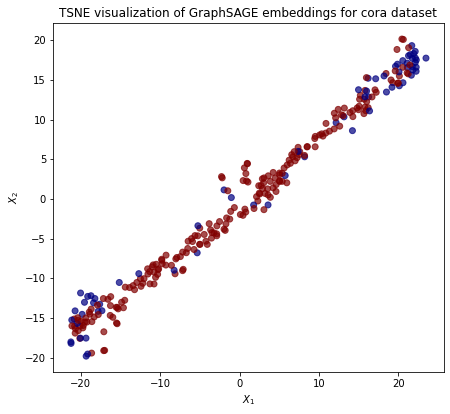

In [11]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GraphSAGE embeddings for cora dataset".format(transform.__name__)
)
plt.show()

Clusters are not separated very goof in their 2d representation, but we check the performance of classifier on embeddings.

#### Train classifier on embeddings

In [12]:
X = node_embeddings
y = np.array(node_subject)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size=0.05, test_size=None, stratify=y
)

In [13]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print("True values:")
pp.pprint(y_val)
print("Prediction:")
pp.pprint(y_pred)
prec = precision_score(y_pred, y_val)
recall = recall_score(y_pred, y_val)
f1 = f1_score(y_pred, y_val)
acc = accuracy_score(y_pred, y_val)
rocauc = roc_auc_score(y_pred, y_val)
print("Precision: ", prec)
print("Recall   : ", recall)
print("F1       : ", f1)
print("Accuracy : ", acc)
print("ROCAUC   : ", rocauc)

True values:
array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1], dtype=int8)
Prediction:
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 

All the metrics are quite unimpressive for our particular dataset.